In [2]:
import numpy as np
from HH4b import utils
from HH4b import postprocessing
import xgboost as xgb
import importlib
import hist
import os

import mplhep as hep
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from HH4b.postprocessing.PostProcess import add_bdt_scores

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
bdt_axis = hist.axis.Variable(list(np.arange(0.88, 1, 0.01)), name="BDT score")
#bdt_axis = hist.axis.Variable(list(np.arange(0, 1, 0.01)), name="BDT score")

#txbb1_axis = hist.axis.Variable(list(np.arange(0.8, 1, 0.005)), name="Jet 1 Txbb")
txbb1_axis = hist.axis.Variable(list(np.arange(0.975, 1, 0.005)), name="Jet 1 Txbb")

txbb2_axis = hist.axis.Variable(list(np.arange(0, 1, 0.005)), name="Jet 2 Txbb")


In [5]:
def get_dataframe(events_dict, year, bdt_model_name, bdt_config):
    bdt_model = xgb.XGBClassifier()
    bdt_model.load_model(fname=f"../boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model")
    make_bdt_dataframe = importlib.import_module(
        f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
    )

    bdt_events_dict = {}
    for key in events_dict:
        events = events_dict[key]
        bdt_events = make_bdt_dataframe.bdt_dataframe(events)
        preds = bdt_model.predict_proba(bdt_events)
        # inference
        add_bdt_scores(bdt_events, preds)

        # extra variables
        bdt_events["H1PNetMass"] = events["bbFatJetPNetMassLegacy"][0]
        bdt_events["H2PNetMass"] = events["bbFatJetPNetMassLegacy"][1]
        bdt_events["H1Msd"] = events["bbFatJetMsd"][0]
        bdt_events["H1TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][0]
        bdt_events["H2TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][1]
        bdt_events["weight"] = events["finalWeight"].to_numpy()

        bdt_events["hlt"] = np.any(
            np.array(
                [events[trigger][0] for trigger in postprocessing.HLTs[year] if trigger in events]
            ),
            axis=0,
        )
        mask_hlt = bdt_events["hlt"] == 1

        # masks
        mask_presel = (
            (bdt_events["H1Msd"] > 40)
            & (bdt_events["H1Pt"] > 300)
            & (bdt_events["H2Pt"] > 300)
            & (bdt_events["H1TXbb"] > 0.8)
        )
        mask_mass = (bdt_events["H2PNetMass"] > 50) & (bdt_events["H2PNetMass"] < 250)
        bdt_events = bdt_events[(mask_mass) & (mask_hlt) & (mask_presel)]

        columns = ["bdt_score", "H1TXbb", "H2TXbb", "H1PNetMass", "H2PNetMass", "weight"]
        bdt_events_dict[key] = bdt_events[columns]
    return bdt_events_dict

In [6]:
data_dir = "24May24_v12_private_signal"
input_dir = f"/ceph/cms/store/user/cmantill/bbbb/skimmer/{data_dir}"

samples_run3 = {
    "2022EE": {
        "data": ["JetMET_Run2022E"],
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
    "2022": {
        # "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
    "2023": {
        # "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
    "2023BPix": {
        # "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
}

mass_var = "H2PNetMass"
bdt_model_name = "24May31_lr_0p02_md_8_AK4Away"
bdt_config = "24May31_lr_0p02_md_8_AK4Away"
bdt_events_dict_year = {}
legacy_label = "Legacy"
for year in samples_run3:
    events = postprocessing.load_run3_samples(
        input_dir=input_dir,
        year=year,
        legacy=True,
        samples_run3=samples_run3,
        reorder_txbb=True,
        txbb=f"bbFatJetPNetTXbb{legacy_label}",
    )
    bdt_events_dict_year[year] = get_dataframe(events, year, bdt_model_name, bdt_config)

Loading JetMET_Run2022E
Loaded JetMET_Run2022E                                   : 426191 entries
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 155470 entries


In [7]:
events_combined, scaled_by = postprocessing.combine_run3_samples(
    bdt_events_dict_year,
    ["data", "hh4b"],
    bg_keys=["ttbar"],
    scale_processes={},
    years_run3=bdt_events_dict_year.keys(),
)

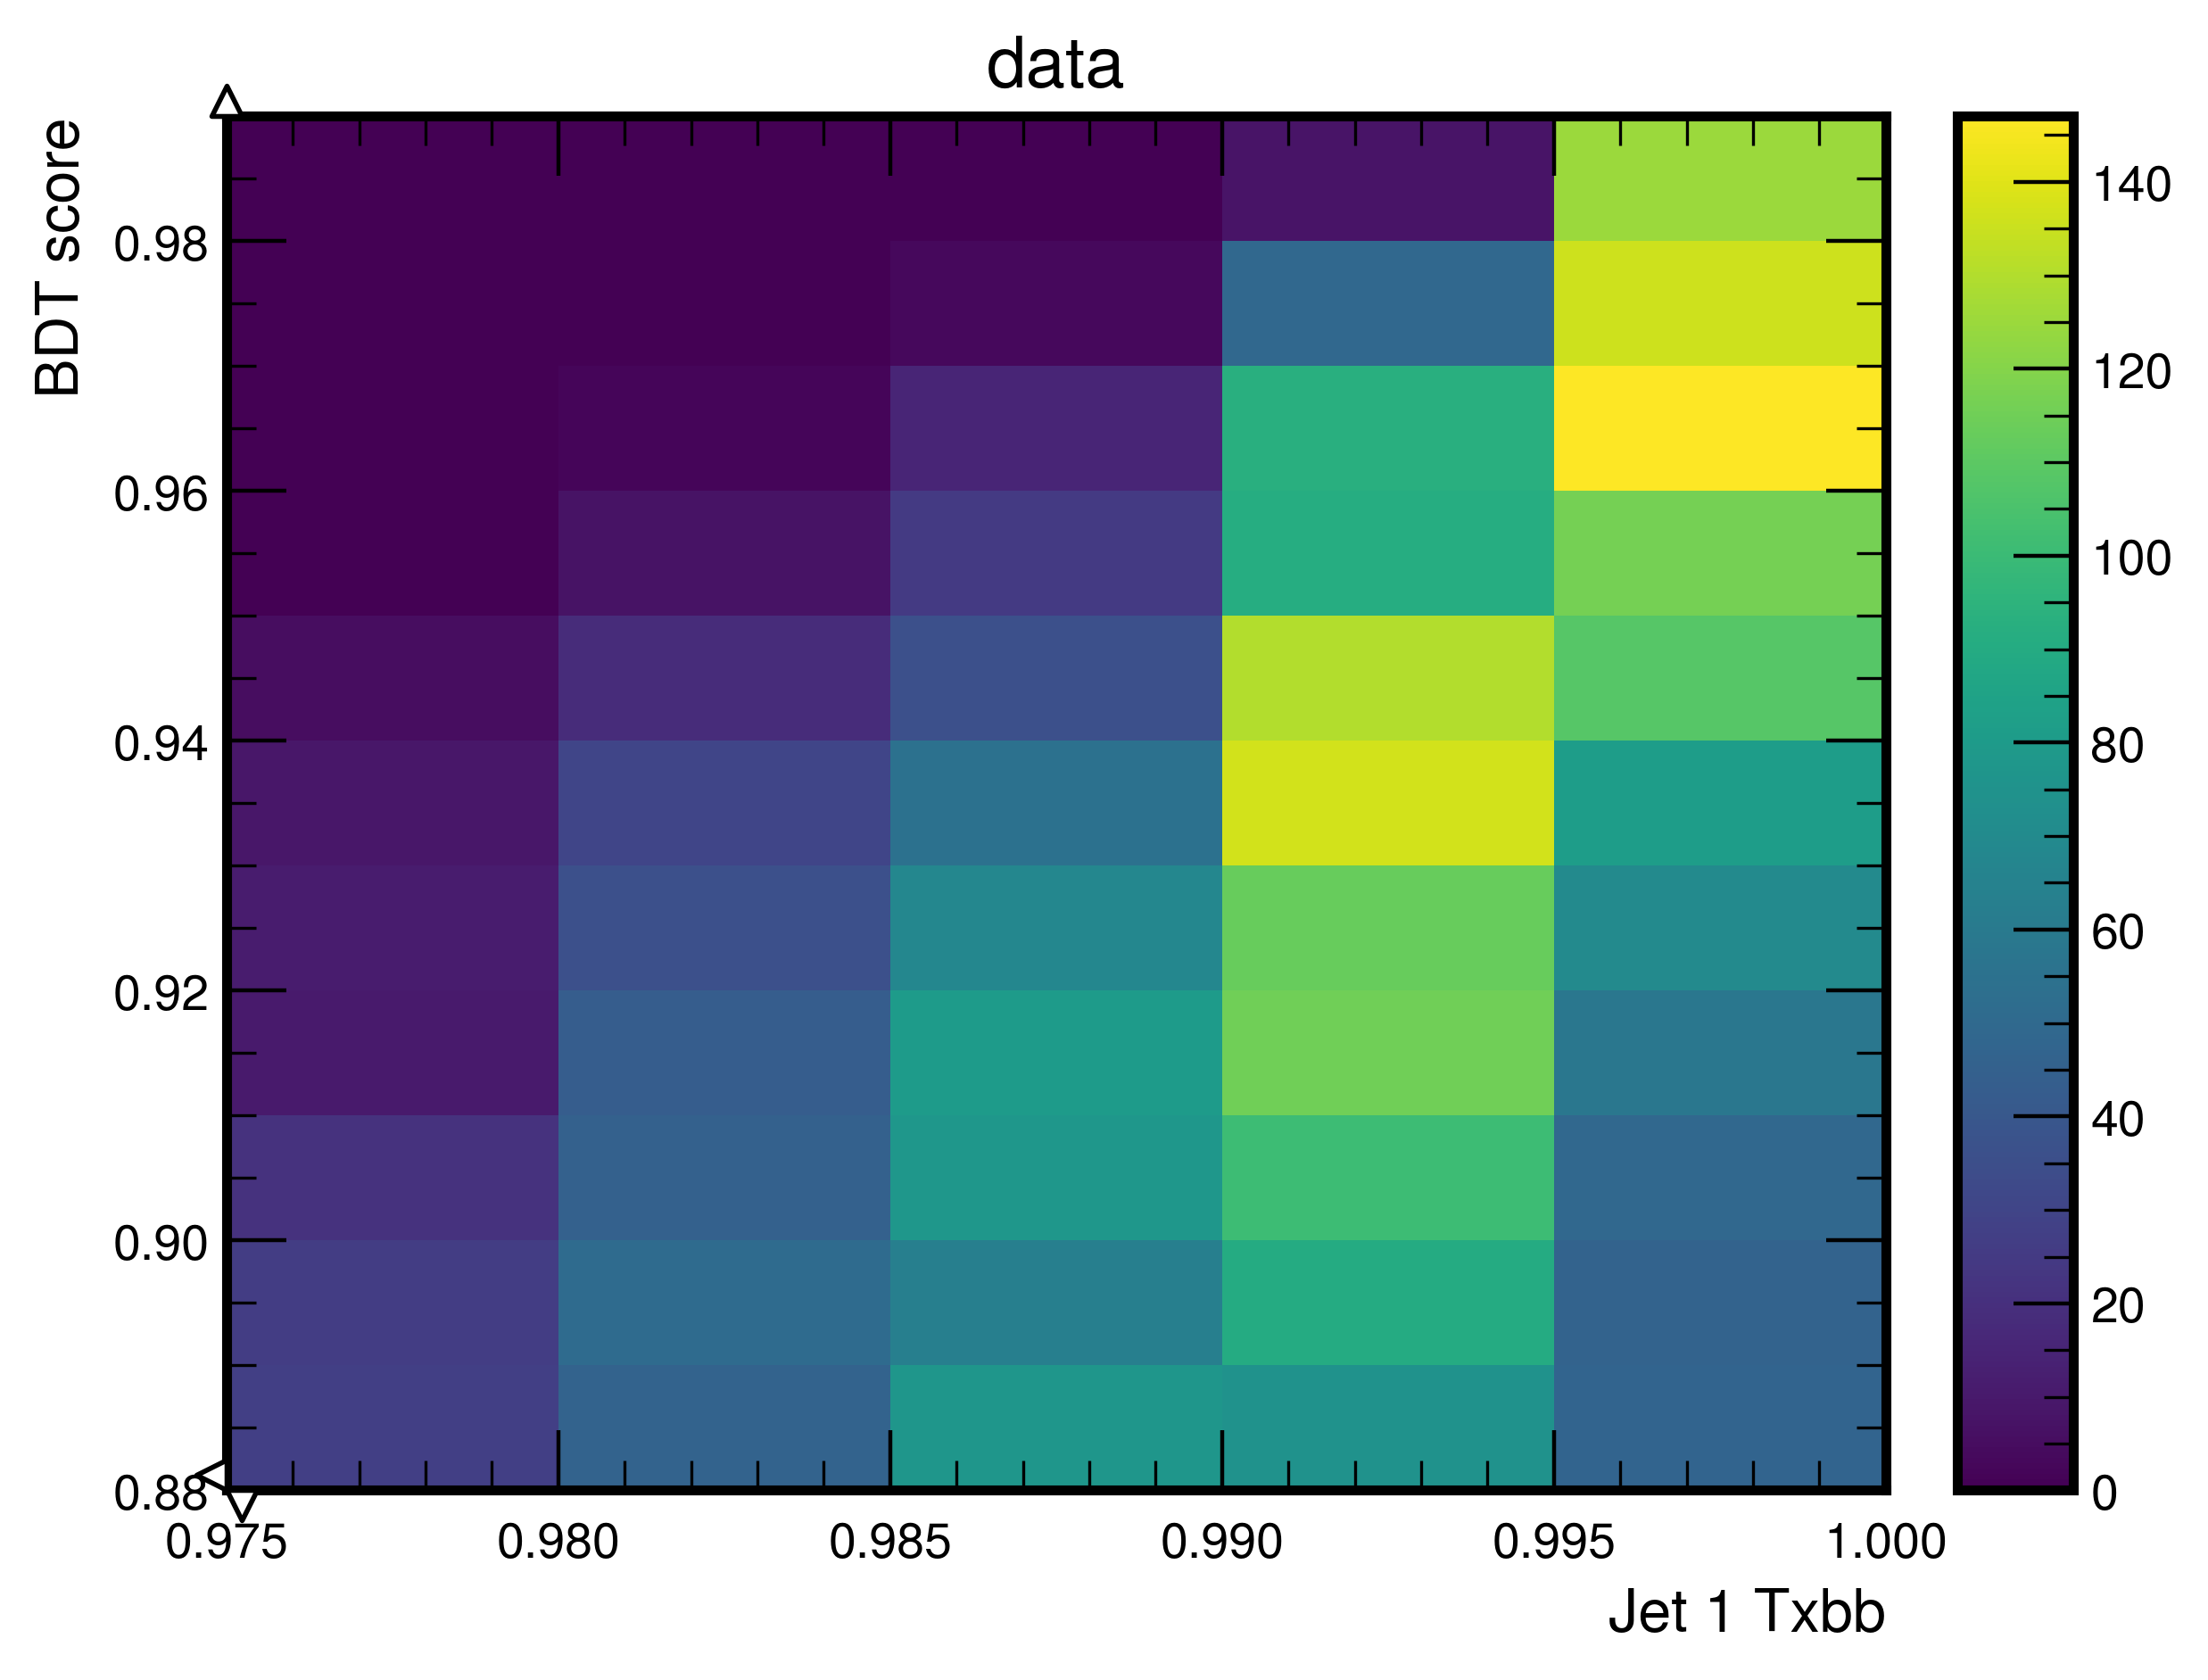

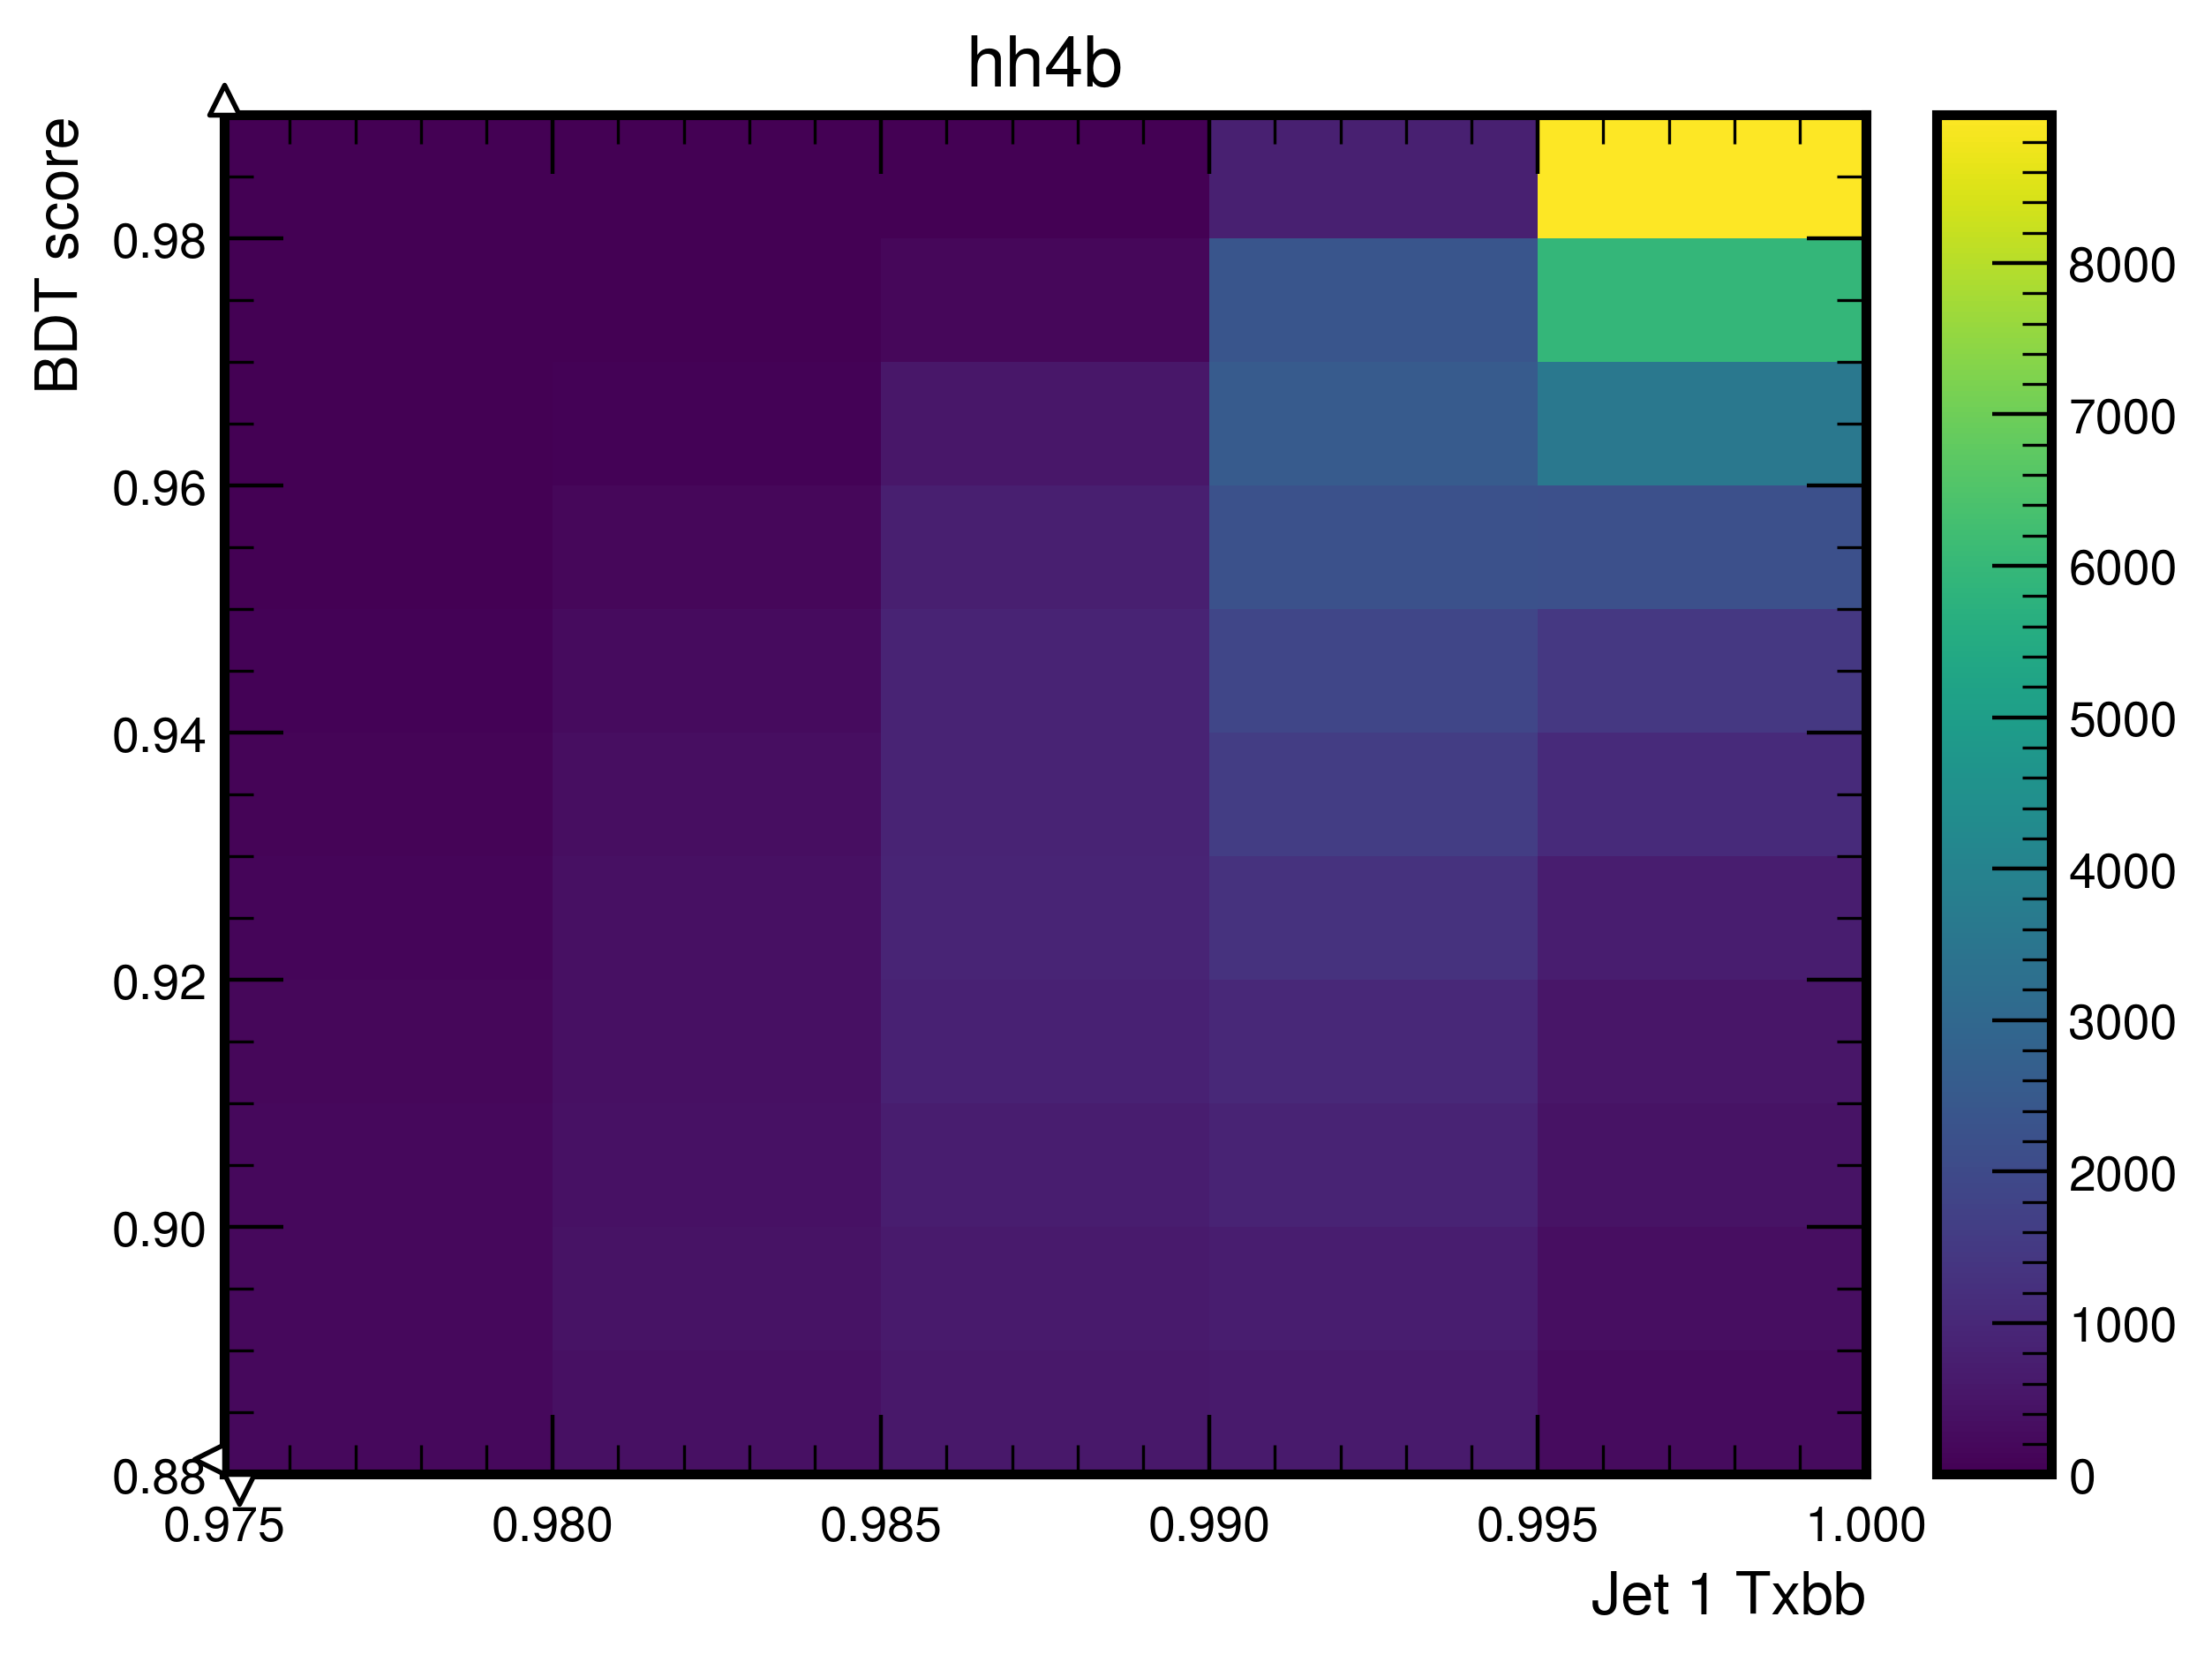

In [8]:
labels = {
    "data": "Jet HT",
    "hh4b": "HH (4b)",
}


for key, events in events_combined.items():

    h_xbb1 = hist.Hist(txbb1_axis, bdt_axis)

    h_xbb1.fill(
        events["H1TXbb"],
        events["bdt_score"]
    )

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1, ax=ax)
    ax.set_title(key)

In [9]:
h_xbb1

Hist(
  Variable([0.975, 0.98, 0.985, 0.99, 0.995, 1], name='Jet 1 Txbb'),
  Variable([0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99], name='BDT score'),
  storage=Double()) # Sum: 51997.0 (105928.0 with flow)